# Exercise 1a

## 1. Monte-Carlo Simulation

### 1.1 Data Creation and Visualization
#### Method
- Let X be a random variable whose distribution can be described by the cumulative distribution function $F_{x}$.
- We want to generate values of X which are distributed according to this distribution.

The inverse transform sampling method works as follows:

1. Generate a random number u from the standard uniform distribution in the interval $[0,1]$.
2. Find the inverse of the desired CDF, e.g. $F^{-1}_{X}(x)$.
3. Compute $X = F^{-1}_{X}(u)$. The computed random variable $X$ has distribution $F_{X}(x)$.
---
Information taken from [Wikipedia](https://en.wikipedia.org/wiki/Inverse_transform_sampling)

#### Application
Sampling $p(Y=0) = p(Y=1) = \frac{1}{2}$
1. Generate a random number u from the standard uniform distribution in the interval $[0,1]$.
2. Round random number to 1 if it is $\geq$ 0.5, otherwise round it to 0.

Sampling $p(X=x|Y=0) = 2-2x$
1. Generate a random number u from the standard uniform distribution in the interval $[0,1]$.
2. Calculate inversion $F^{-1}_{X}(x)$
$$F_{X}(x) = \int_{0}^{x}  2-2x\,dx $$
$$F_{X}(x) = 2x-x^{2} $$
$$F^{-1}_{X}(x) = 1-\sqrt{1-x}, 1+\sqrt{1-x}$$

3. Compute $X = 1-\sqrt{1-u}$, as the other case is not in range of $[0,1]$. The computed random variable $X$ has distribution $2-2x$

Sampling $p(X=x|Y=1) = 2x$
1. Generate a random number u from the standard uniform distribution in the interval $[0,1]$.
2. Calculate inversion $F^{-1}_{X}(x)$
$$F_{X}(x) = \int_{0}^{x}  2x\,dx $$
$$F_{X}(x) = x^{2} $$
$$F^{-1}_{X}(x) = -\sqrt{x}, \sqrt{x}$$

3. Compute $X = \sqrt{u}$, as the other case is not in range of $[0,1]$. The computed random variable $X$ has distribution $2x$

In [1]:
import numpy.random as random
import numpy as np
import math as math
import matplotlib.pyplot as plt

In [104]:
def p0():
    return 1- math.sqrt(1-random.random())

def p1():
    return math.sqrt(random.random())


# create labels and ensure that at least one of each label is present
def create_labels(N):
    assert N >= 2
    
    Y = random.randint(0, 2, size=N)
    
    while sum(Y) in [0, len(Y)]:
        Y = random.randint(0, 2, size=N)


def create_data (N):    
    Y = random.randint(0, 2, size=N)
    X = np.vectorize(lambda x: p0() if x == 0 else p1())

    return X(Y), Y

In [9]:
X, Y = create_data(1000000)

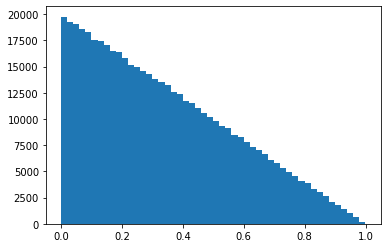

In [15]:
plt1 = plt.hist([x for x, y in zip(X, Y) if y == 0], bins=50)

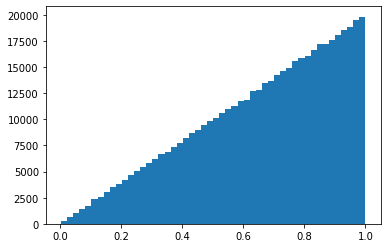

In [17]:
plt2 = plt.hist([x for x, y in zip(X, Y) if y == 1], bins=50)

### 1.2 Classification by Thresholding

In [19]:
def fA(X,x_t):
    return int(X >= x_t)

def fB(X,x_t):
    return int(X < x_t)

In [54]:
def test(M, t, f):
    errors = []
    for i in range(10):
        X, Y = create_data(M)

        predictions = [f(x, t) for x in X]
        wrong_prediction = [p != y for p, y in zip(predictions, Y)]
        
        error = sum(wrong_prediction) / len(X)

        errors.append(error)
    return errors

In [50]:
def mean_error(error_rates):
    return sum(error_rates) / len(error_rates)

def standard_deviation_error(mean_error, error_rates):
    return sum([abs(mean_error - elem) for elem in error_rates]) / len(error_rates)

In [42]:
TEST_DATA_SIZES = [10, 100, 1000, 10_000]

def experiment(threshold, f):
    test_results = [test(size, threshold, f) for size in TEST_DATA_SIZES]
    mean_errors = [mean_error(result) for result in test_results]
    std_deviations = [standard_deviation_error(mean_error, result) 
                          for mean_error, result in zip(mean_errors, test_results)]
    
    plt.plot(TEST_DATA_SIZES, mean_errors, label="t = "+str(threshold))
    plt.errorbar(TEST_DATA_SIZES, mean_errors, yerr=std_deviations, ecolor="red" ,ls="None")
    plt.legend(loc="lower right")
    plt.xscale("log")

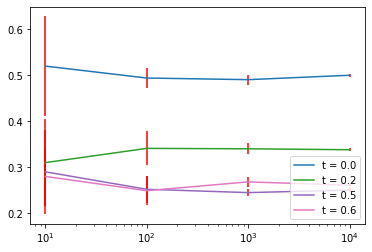

In [55]:
experiment(0.0, fA)
experiment(0.2, fA)
experiment(0.5, fA)
experiment(0.6, fA)

Theoretical error rates:
$$p(error|A;x_{t}) = \frac{1}{4} + (x_{t} - \frac{1}{2})^{2}$$
$$p(error|A;0.0) = \frac{1}{4} + (0.0 - \frac{1}{2})^{2} = 0.5$$
$$p(error|A;0.2) = \frac{1}{4} + (0.2 - \frac{1}{2})^{2} = 0.34$$
$$p(error|A;0.5) = \frac{1}{4} + (0.5 - \frac{1}{2})^{2} = 0.25$$
$$p(error|A;0.6) = \frac{1}{4} + (0.6 - \frac{1}{2})^{2} = 0.26$$

The error standard deviation decreases exponentially with increasing M.
If one compares the expected error rates with the computed error rates, one can see that they are equal for $ M \to \infty $.


### 1.3 Baseline Classifiers

In [47]:
def fC(X,t):
    r = random.random()
    u = 1 if r >= 0.5 else 0
    return u

def fD(X,t):
    return 1

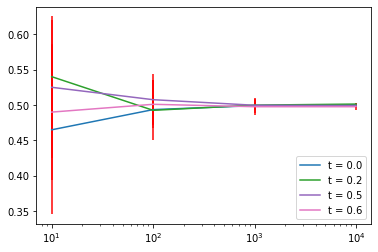

In [48]:
experiment(0.0, fC)
experiment(0.2, fC)
experiment(0.5, fC)
experiment(0.6, fC)

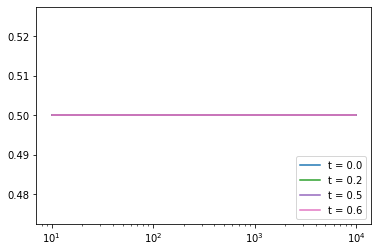

In [49]:
experiment(0.0, fD)
experiment(0.2, fD)
experiment(0.5, fD)
experiment(0.6, fD)

### 1.4 Nearest Neighbor Classification

In [99]:
def toy_nearest_neighbor_singular(X, Xtrain, Ytrain):
    diff = np.array(list(map(lambda elem: abs(X - elem), Xtrain)))
    smallestElemIndex = np.argmin(diff)
    Y = Ytrain[smallestElemIndex]
    return Y 

def toy_nearest_neighbor(Xtest, Xtrain, Ytrain):
    Ytest = list(map(lambda elem: toy_nearest_neighbor_singular(elem, Xtrain, Ytrain), Xtest))
    return Ytest

In [57]:
def testNNC(N, M):
    Xtrain, Ytrain = create_data(N)
    Xtest, Ytest = create_data(M)

    predictions = toy_nearest_neighbor(Xtest, Xtrain, Ytrain)

    errors = sum([p != y for p, y in zip(predictions, Ytest)])
    error_rate = errors / len(Ytest)
    return error_rate

In [97]:
def experimentNCC(WDH, N, M):
    error_rates = []
    for i in range(WDH):
        error_rate = testNNC(N, M)
        error_rates.append(error_rate)
    return sum(error_rates) / len(error_rates)

In [105]:
experimentNCC(100, 2, 100)

0.44839999999999997

In [65]:
experimentNCC(100, 100, 100)

0.32239999999999996